# Project: Improving Disaster Resilience

## NOAA Clustering Counties by Events

### 
### Disaster Resilience Project

### Data Used: NOAA Storm Events Details from 1996 to 2022

Andrew Sommers

### Purpose

- Cluster US counties based on NOAA events


#### History 🗓️

   Date | Person | Details
   ---- | ------ | -------
 - 06/12/2023| Andrew Sommers| Create initial notebook
 - 08/25/2023| Andrew Sommers| Updated documentation




### Importing Libraries

We start by importing the libraries required for this notebook, adding in the ACS API key, and creating the function `json_to_dataframe` which is the function used in all our notebooks that make a call to the API. This function converts the API response into a dataframe and a readable format.

In [12]:
#import requests # request http, api
import pandas as pd # tabluar data
#from functools import reduce
import numpy as np
import os

import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

#import k means cluserting from sklearn
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')


pd.options.display.max_columns = None # show all columns in display
pd.options.display.max_rows = None # show all columns in display

In [13]:
# change the notebooks data source directory to the Disaster Resilience  Directory - change this for your local environment
# set the sourcing directory where the 'data folder is located; this is the raw data input files.  
# this notebook assumes data files are located in a 'Data' folder in the following path:
os.chdir('C:\\Users\\andre\\OneDrive\\Documents\\IndianaUniversity\\D592\\Project_Disaster_Resilience\\Data\\Tables')
FIPS_Table = pd.read_csv(f'FIPS_Prepared_Table.csv', dtype = str, skipinitialspace = True)
FIPS_Table.set_index("FIPS", inplace = True)
len(FIPS_Table)

3143

In [39]:
FIPS_Table.head(3)

,STATE_CODE,STATE_FIPS,COUNTY_FIPS,COUNTY_NS,COUNTY_FULL_NAME,FIPS_CLASS_CODE,FUNCTION_STATUS,COUNTY,STATE
FIPS,,,,,,,,,
0500000US01001,AL,1,1,161526,Autauga County,H1,A,AUTAUGA,ALABAMA
0500000US01003,AL,1,3,161527,Baldwin County,H1,A,BALDWIN,ALABAMA
0500000US01005,AL,1,5,161528,Barbour County,H1,A,BARBOUR,ALABAMA


In [14]:
# this function modifies the NOAA data to have similar events and data columns as the FEMA summary data
def get_NOAA_data(threshold):
    
    # read the input csv from the Data directory given the path in the prior cell - all columns set to type string
    os.chdir('C:\\Users\\andre\\OneDrive\\Documents\\IndianaUniversity\\D592\\Project_Disaster_Resilience\\Data\\NOAA')
    NOAA_History_Adjusted = pd.read_csv(f'NOAA_FIPS_Normalized_EventHistory_1996_2022.csv')
    NOAA_History_Adjusted['DAMAGE_PROPERTY'] = NOAA_History_Adjusted['DAMAGE_PROPERTY'].astype(float)
    NOAA_History_Adjusted['DAMAGE_CROPS'] = NOAA_History_Adjusted['DAMAGE_CROPS'].astype(float)
    NOAA_History_Adjusted = NOAA_History_Adjusted[NOAA_History_Adjusted['DAMAGE_PROPERTY'] >= threshold] #keep only events with a property damage of greater than threshold
    print('Length of NOAA input file ', len(NOAA_History_Adjusted))
    
    # map events to standard FEMA incident Types - use the same consolidated list of FEMA incident types applied to the FEMA data
    NOAA_mapping = {
        'Hurricane': 'Hurricanes and Tropical Storms',
        'Hurricane (Typhoon)': 'Hurricanes and Tropical Storms',
        'Tropical Depression': 'Hurricanes and Tropical Storms',
        'Tropical Storm': 'Hurricanes and Tropical Storms',
        'Marine Hurricane/Typhoon': 'Hurricanes and Tropical Storms',
        'Marine Hail': 'Marine Severe Storms',
        'Marine High Wind': 'Marine Severe Storms',
        'Marine Strong Wind': 'Marine Severe Storms',
        'Marine Thunderstorm Wind': 'Marine Severe Storms',
        'Coastal Flood': 'Marine Costal and Wave Events',
        'High Surf': 'Marine Costal and Wave Events',
        'Rip Current': 'Marine Costal and Wave Events',
        'Sneakerwave' : 'Marine Costal and Wave Events',
        'Seiche': 'Marine Costal and Wave Events',
        'Storm Surge/Tide': 'Marine Costal and Wave Events',
        'Waterspout': 'Marine Costal and Wave Events',
        'Tsunami': 'Marine Costal and Wave Events',
        'Debris Flow': 'Flood and Related Events',
        'Flash Flood': 'Flood and Related Events',
        'Flood': 'Flood and Related Events',
        'Lakeshore Flood': 'Flood and Related Events',
        'Drought': 'Drought',
        'Dense Smoke': 'Fire and Related Events',
        'Wildfire': 'Fire and Related Events',
        'Blizzard': 'Winter Storms',
        'Heavy Snow': 'Winter Storms',
        'Ice Storm': 'Winter Storms',
        'Lake-Effect Snow': 'Winter Storms',
        'Sleet': 'Winter Storms',
        'Winter Storm': 'Winter Storms',
        'Winter Weather': 'Winter Storms',
        'Cold/Wind Chill': 'Winter Cold and Freezing',
        'Extreme Cold/Wind Chill': 'Winter Cold and Freezing',
        'Freezing Fog': 'Winter Cold and Freezing',
        'Frost/Freeze': 'Winter Cold and Freezing',
        'Funnel Cloud':'Tornado',
        'Tornado':'Tornado',
        'Hail': 'Severe Storms and Wind',
        'Heavy Rain': 'Severe Storms and Wind',
        'High Wind': 'Severe Storms and Wind',
        'Lightning': 'Severe Storms and Wind',
        'Strong Wind': 'Severe Storms and Wind',
        'Thunderstorm Wind': 'Severe Storms and Wind',    
        'Dust Devil': 'Dust Storm',
        'Dust Storm': 'Dust Storm',
        'Dense Fog': 'Other Events - Consolidated',        
        'Astronomical Low Tide': 'Other Events - Consolidated',
        'Avalanche': 'Other Events - Consolidated',
        'Excessive Heat': 'Other Events - Consolidated',
        'Heat': 'Other Events - Consolidated',
        'Volcanic Ash': 'Other Events - Consolidated',
        'Northern Lights': 'Other Events - Consolidated'
    }
    # map the NOAA EVENT TYPE to Combined FEMA incident types
    NOAA_History_Adjusted["EVENT_TYPE"] = NOAA_History_Adjusted["EVENT_TYPE"].map(lambda x: NOAA_mapping[x])
    # drop incident types classified as 'Other':  unique, non-reocurring or localized incidents
    NOAA_History_Adjusted = NOAA_History_Adjusted[NOAA_History_Adjusted['EVENT_TYPE'] != 'Other Events - Consolidated']
         
    #rename columns to use standard FEMA columne names 
    NOAA_History_Analysis = NOAA_History_Adjusted[['FIPS','YEAR','EVENT_TYPE', 'DAMAGE_PROPERTY']].copy()
    NOAA_History_Analysis.rename(columns={'EVENT_TYPE': 'incidentType'}, inplace=True)
      
    return NOAA_History_Analysis

In [15]:
minimum_threshold = 25000  # minimum property damage to be included in trend analysis
df_NOAA_Results = get_NOAA_data(minimum_threshold)
df_NOAA_Incidents = df_NOAA_Results[['FIPS', 'incidentType']].copy()
print("data load complete", len(df_NOAA_Incidents))

Length of NOAA input file  81887
data load complete 81761


In [16]:
df_NOAA_Results.head(3)

,FIPS,YEAR,incidentType,DAMAGE_PROPERTY
4,0500000US48309,1996,Severe Storms and Wind,25000.0
17,0500000US39101,1996,Winter Storms,100000.0
93,0500000US46005,1996,Severe Storms and Wind,40000.0


In [17]:
df_NOAA_Results['YEAR'] = pd.to_numeric(df_NOAA_Results['YEAR'])
df_NOAA_Damage = df_NOAA_Results.loc[(df_NOAA_Results['YEAR'] > 2005) & (df_NOAA_Results['YEAR'] < 2023)].reset_index().copy() 
# example to filter rows: df.loc[(df['Discount'] >= 1000) & (df['Discount'] <= 2000)]

In [18]:
#len(df_NOAA_Damage)
df_NOAA_Damage.tail(3)

,index,FIPS,YEAR,incidentType,DAMAGE_PROPERTY
59949,1062369,0500000US22109,2022,Tornado,100000.0
59950,1062382,0500000US22111,2022,Tornado,1200000.0
59951,1062497,0500000US22017,2022,Tornado,500000.0


 ### create the total NOAA property damage values by FIPS code (by county)

In [19]:
# use pandas crosstab to generate a new dataframe of counts of disasters per year
#
df_NOAA_Damage['FIPS_Xref'] = df_NOAA_Damage['FIPS']
#dfDisasterCosts = pd.crosstab(index = df_NOAA_Results.FIPS, columns = df_NOAA_Results.FIPS_Xref, values = df_NOAA_Results.DAMAGE_PROPERTY, aggfunc = 'mean').stack().reset_index().rename(columns={0:'Avg_Annual_Cost'})
dfDisasterCosts = pd.crosstab(index = df_NOAA_Damage.FIPS, columns = df_NOAA_Damage.FIPS_Xref, values = df_NOAA_Damage.DAMAGE_PROPERTY, aggfunc = 'sum').stack().reset_index().rename(columns={0:'Total_Property_Damage'})
dfDisasterCosts = dfDisasterCosts.sort_values(by=['FIPS'])
dfDisasterCosts['Total_Property_Damage'] = dfDisasterCosts['Total_Property_Damage'].fillna(0)
dfDisasterCosts['Total_Property_Damage'] = round(dfDisasterCosts['Total_Property_Damage'], 0)
dfDisasterCosts.drop(['FIPS_Xref'], axis=1, inplace = True)
dfDisasterCosts.set_index('FIPS', inplace = True)
dfDisasterCosts.head(3)

,Total_Property_Damage
FIPS,
0500000US01001,14304600.0
0500000US01003,30850000.0
0500000US01005,555000.0


### create the sum of count of NOAA events by FIPS code (by county) for each NOAA event classification

In [20]:
# use pandas crosstab to generate a new dataframe of counts of disasters per year
#
dfDisasterCounts = pd.crosstab(df_NOAA_Incidents.incidentType,df_NOAA_Incidents.FIPS).stack().reset_index().rename(columns={0:'Count'})
dfDisasterCounts = dfDisasterCounts.sort_values(by=['FIPS'])
dfDisasterCounts['Count'] = dfDisasterCounts['Count'].fillna(0)
#dfDisasterCounts.rename(columns = {"fyDeclared":"Years"}, inplace = True) #add the FEMA funding by FIPS to the NOAA FIPS level data
dfDisastersPivot = dfDisasterCounts.pivot(index = 'FIPS', columns = 'incidentType', values = 'Count') #add the NOAA property damage by FIPS to the NOAA event counts by FIPS
dfDisastersPivot.head(5)

incidentType,Drought,Dust Storm,Fire and Related Events,Flood and Related Events,Hurricanes and Tropical Storms,Marine Costal and Wave Events,Marine Severe Storms,Severe Storms and Wind,Tornado,Winter Cold and Freezing,Winter Storms
FIPS,,,,,,,,,,,
0500000US01001,0,0,0,6,1,0,0,10,11,0,0
0500000US01003,0,0,0,12,0,0,0,16,7,0,0
0500000US01005,0,0,0,2,1,0,0,3,4,0,0
0500000US01007,0,0,0,3,1,0,0,3,4,0,0
0500000US01009,0,0,0,2,1,0,0,15,12,0,1


In [21]:
df1 = dfDisastersPivot[[]].copy()
County_Disasters_Count = df1.join(dfDisastersPivot).copy()
# removed adding property damage for NOAA clustering because property damage causes highly uneven clusters
#County_Disasters_Count = County_Disasters_Count.join(dfDisasterCosts['Total_Property_Damage'], how = 'left')
#County_Disasters_Count['Total_Property_Damage'] = County_Disasters_Count['Total_Property_Damage'].fillna(0)
len(County_Disasters_Count)

3019

In [11]:
County_Disasters_Count.head(3)

incidentType,Drought,Dust Storm,Fire and Related Events,Flood and Related Events,Hurricanes and Tropical Storms,Marine Costal and Wave Events,Marine Severe Storms,Severe Storms and Wind,Tornado,Winter Cold and Freezing,Winter Storms
FIPS,,,,,,,,,,,
0500000US01001,0,0,0,6,1,0,0,10,11,0,0
0500000US01003,0,0,0,12,0,0,0,16,7,0,0
0500000US01005,0,0,0,2,1,0,0,3,4,0,0


### unsupervised clustering using k-means
##### https://towardsdatascience.com/how-to-perform-kmeans-clustering-using-python-7cc296cec092

In [22]:
def find_best_clusters(df, maximum_K):
    
    clusters_centers = []
    k_values = []
    
    for k in range(1, maximum_K):
        
        kmeans_model = KMeans(n_clusters = k)
        kmeans_model.fit(df)
        
        clusters_centers.append(kmeans_model.inertia_)
        k_values.append(k)
        
    
    return clusters_centers, k_values

In [23]:
def generate_elbow_plot(clusters_centers, k_values):
    
    figure = plt.subplots(figsize = (12, 6))
    plt.plot(k_values, clusters_centers, 'o-', color = 'orange')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Cluster Inertia")
    plt.title("Elbow Plot of KMeans")
    plt.show()

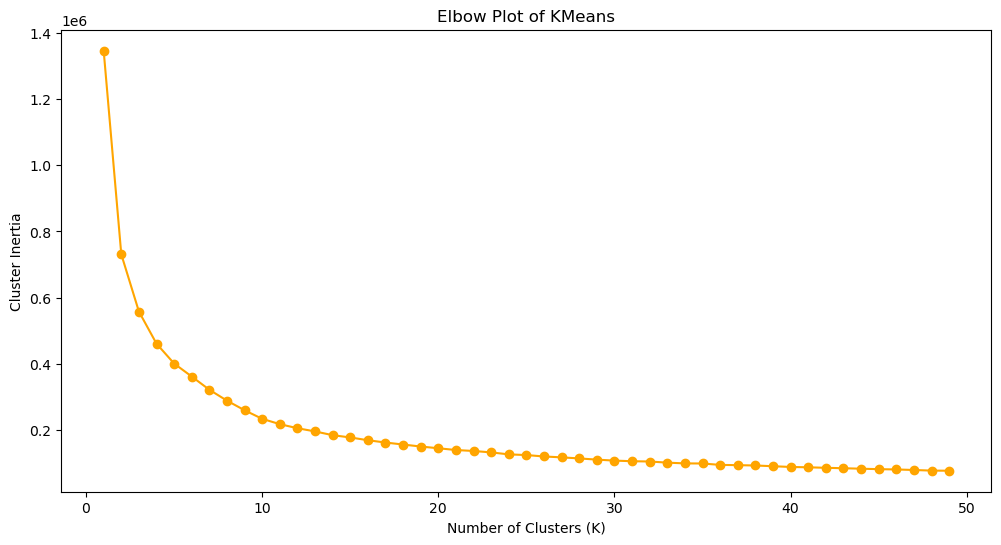

In [24]:
clusters_centers, k_values = find_best_clusters(County_Disasters_Count, 50)
generate_elbow_plot(clusters_centers, k_values)

In [25]:
kmeans_model = KMeans(n_clusters = 7)
kmeans_model.fit(County_Disasters_Count)
County_Disasters_Output = County_Disasters_Count.copy()
County_Disasters_Output["cluster"] = kmeans_model.labels_
extract = FIPS_Table.STATE
County_Disasters_Output["State"] = extract
extract = FIPS_Table.COUNTY
County_Disasters_Output["County"] = extract
print("county clusters completed for ", len(County_Disasters_Output))

county clusters completed for  3019


In [26]:
County_Disasters_Output.head(3)

incidentType,Drought,Dust Storm,Fire and Related Events,Flood and Related Events,Hurricanes and Tropical Storms,Marine Costal and Wave Events,Marine Severe Storms,Severe Storms and Wind,Tornado,Winter Cold and Freezing,Winter Storms,cluster,State,County
FIPS,,,,,,,,,,,,,,
0500000US01001,0,0,0,6,1,0,0,10,11,0,0,4,ALABAMA,AUTAUGA
0500000US01003,0,0,0,12,0,0,0,16,7,0,0,4,ALABAMA,BALDWIN
0500000US01005,0,0,0,2,1,0,0,3,4,0,0,1,ALABAMA,BARBOUR


In [27]:
County_Disasters_Output = County_Disasters_Output.astype({'State':'string'})
County_Disasters_Output['State'].str.strip()
County_Disasters_Output = County_Disasters_Output.astype({'County':'string'})
County_Disasters_Output['County'].str.strip()
County_Disasters_Output = County_Disasters_Output.join(dfDisasterCosts['Total_Property_Damage'], how = 'left') 
County_Disasters_Output['Total_Property_Damage'] = County_Disasters_Output['Total_Property_Damage'].fillna(0)
#County_Disasters_Output = County_Disasters_Output.join(dfFEMAFunding['Total_FEMA_Funding'], how = 'left')
County_Disasters_Output.head(3)

,Drought,Dust Storm,Fire and Related Events,Flood and Related Events,Hurricanes and Tropical Storms,Marine Costal and Wave Events,Marine Severe Storms,Severe Storms and Wind,Tornado,Winter Cold and Freezing,Winter Storms,cluster,State,County,Total_Property_Damage
FIPS,,,,,,,,,,,,,,,
0500000US01001,0,0,0,6,1,0,0,10,11,0,0,4,ALABAMA,AUTAUGA,14304600.0
0500000US01003,0,0,0,12,0,0,0,16,7,0,0,4,ALABAMA,BALDWIN,30850000.0
0500000US01005,0,0,0,2,1,0,0,3,4,0,0,1,ALABAMA,BARBOUR,555000.0


In [28]:
df1 = County_Disasters_Output[County_Disasters_Output['State'].str.contains("INDIANA")]
df1.head(3)

,Drought,Dust Storm,Fire and Related Events,Flood and Related Events,Hurricanes and Tropical Storms,Marine Costal and Wave Events,Marine Severe Storms,Severe Storms and Wind,Tornado,Winter Cold and Freezing,Winter Storms,cluster,State,County,Total_Property_Damage
FIPS,,,,,,,,,,,,,,,
0500000US18001,0,0,0,2,0,0,0,4,0,0,1,1,INDIANA,ADAMS,401000.0
0500000US18003,0,0,0,2,0,0,0,15,1,0,1,4,INDIANA,ALLEN,1990000.0
0500000US18005,0,0,0,12,0,0,0,8,2,0,2,1,INDIANA,BARTHOLOMEW,251125000.0


In [29]:
df1 = County_Disasters_Output[County_Disasters_Output['cluster'] == 1] # manually input cluster for the county of interest
os.chdir('C:\\Users\\andre\\OneDrive\\Documents\\IndianaUniversity\\D592\\Project_Disaster_Resilience\\Data\\NOAA')
df1.reset_index(inplace=True)
df1 = df1.rename(columns = {'index':'FIPS'})
df1.to_csv(f'NOAA_BartholomewCluster_All_Counties.csv', header=True, index=False)
print('end of cluster generation and save function', len(df1))

end of cluster generation and save function 1877


In [34]:
df1.head(3)

,FIPS,Drought,Dust Storm,Fire and Related Events,Flood and Related Events,Hurricanes and Tropical Storms,Marine Costal and Wave Events,Marine Severe Storms,Severe Storms and Wind,Tornado,Winter Cold and Freezing,Winter Storms,Total_Property_Damage,cluster,State,County
0,0500000US01031,0,0,0,5,7,0,0,26,6,0,1,258442500.0,6,ALABAMA,COFFEE
1,0500000US01115,0,0,0,6,1,0,0,14,10,0,5,202052000.0,6,ALABAMA,ST. CLAIR
2,0500000US05031,0,0,0,20,1,0,0,52,17,0,4,312308000.0,6,ARKANSAS,CRAIGHEAD


In [30]:
df2 = df1[df1['State'].str.contains("INDIANA")] #extract only Indiana counties for cluster of interest
os.chdir('C:\\Users\\andre\\OneDrive\\Documents\\IndianaUniversity\\D592\\Project_Disaster_Resilience\\Data\\NOAA')
df2.to_csv(f'NOAA_BartholomewCluster_Indiana_Counties.csv', header=True, index=False)
print('end of cluster generation and save function', len(df2))

end of cluster generation and save function 66


In [32]:
# output the normalized data to a csv file
os.chdir('C:\\Users\\andre\\OneDrive\\Documents\\IndianaUniversity\\D592\\Project_Disaster_Resilience\\Data\\NOAA')
County_Disasters_Output.reset_index(inplace=True)
County_Disasters_Output = County_Disasters_Output.rename(columns = {'index':'FIPS'})
County_Disasters_Output.to_csv(f'NOAA_AllClusters_All_Counties.csv', header=True, index=False)
print('end of cluster generation and save function', len(County_Disasters_Output))

end of cluster generation and save function 3019
